### Sound file loading

In [2]:
# 소스 출처 : 파이토치 딥러닝 프로젝트 모음집

In [1]:
import librosa

In [2]:
bird_audio, bird_sr = librosa.load("Test_Squeak.wav", sr = 44100)   # 실제 파일은 52.6k Hz


print( f'audio vector length : {len(bird_audio)}\naudio file length : {len(bird_audio)/bird_sr} sec')

audio vector length : 2642472
audio file length : 59.92 sec


In [3]:
print(bird_sr)   # 미리 지정한 Sample Rate로 로딩 (230206)

44100


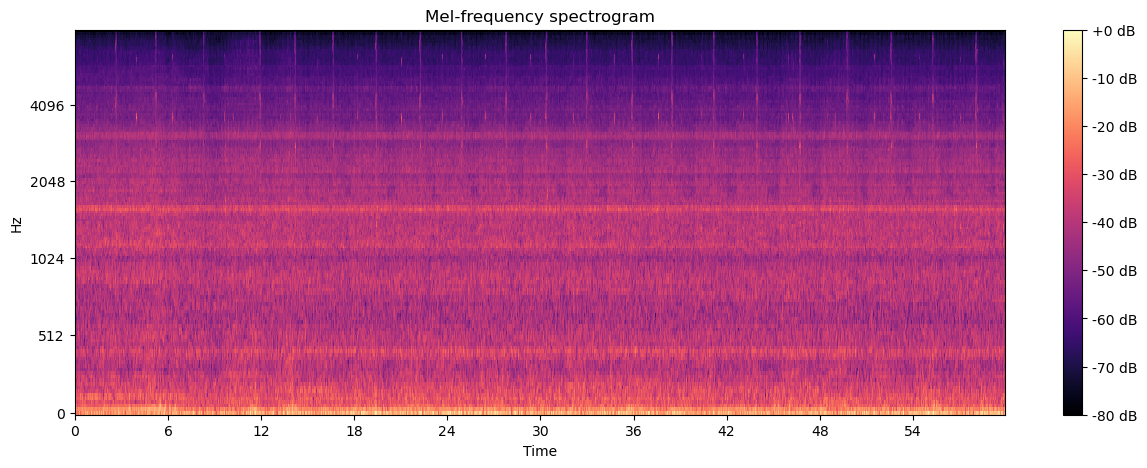

In [4]:
import librosa
from librosa.display import specshow
from matplotlib import pyplot as plt
import numpy as np

S = librosa.feature.melspectrogram(y=bird_audio, sr=bird_sr)

fig, ax = plt.subplots(figsize=(15, 5))
S_dB = librosa.power_to_db(S, ref=np.max)
img = specshow(S_dB, x_axis='time', y_axis='mel', sr=bird_sr, fmax=8000, ax=ax)

fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
plt.show()

In [5]:
# 고주파 대역에서 마찰 소음을 나타내는 스펙트럼 특성
# 각 소음을 포함하는 1초 구간의 영역을 소음 발생 특성으로 정의하고 라벨링 (0 : 소음이 발생, 1: 소음 없음)

### Label data loading

In [6]:
# 음원에 대한 라벨을 별도로 미리 처리

import pandas as pd

# 시작 초 tab 종료 초 tab 라벨(0 or 1)로 데이터만 있는 텍스트 파일
bird_label = pd.read_csv('Test_Squeak_1s.txt', sep='\t', names=['start(s)', 'end(s)', 'label'])
print(f'label :\n{bird_label}')

# 소음이 발생한 구간만 '0'으로 라벨 처리한 결과

label :
     start(s)     end(s)  label
0    3.648525   4.724372      0
1    5.882077   6.922842      0
2    9.249945  10.395956      0
3   12.804918  13.857377      0
4   15.073552  16.126011      0
5   17.739781  18.745464      0
6   20.324153  21.481858      0
7   23.212568  24.358579      0
8   25.820328  27.059891      0
9   28.767213  29.878142      0
10  31.643934  32.719781      0
11  34.146448  35.432787      0
12  37.034863  38.075628      0
13  39.677705  40.776940      0
14  42.437486  43.606885      0
15  50.845464  51.921311      0
16  53.920984  54.950055      0
17  56.821093  57.756612      0
18  59.171585  60.013552      0


In [7]:
bird_label.head()   # 데이터 프레임으로 출력

,start(s),end(s),label
0,3.648525,4.724372,0
1,5.882077,6.922842,0
2,9.249945,10.395956,0
3,12.804918,13.857377,0
4,15.073552,16.126011,0


### Frame Peocessing and Matching (짝 맞추기)

#### Frame size, Stride 설정

In [8]:
# 1초 이상 지속되는 구간만 Frame으로 선정
# 본 예제에서는 라벨 구간이 모두 1초를 초과한다.
# 라벨 설정 시 1초 이상으로 넓게 잡을 것, 뒤에 코드 수정이 힘든 문제 (230203)

frame_size = 1      # 프레임 사이즈 0.05초, 0.05초 미만의 짧은 레이블 정보는 사용하지 않음
stride = 0.1        # 여러개의 Frame 확보 가능함, 예를 들어 ~0.05초 구간에서 총 4개의 프레임 확보 가능

idx = bird_label['end(s)'] - bird_label['start(s)'] >= frame_size
bird_label = bird_label[idx]      # idx가 true인 값만 가져옴

# 소음이 발생하는 구간을 1초 단위로 더 잘게 나누는 과정
# stride를 적용하여 더 많은 샘플 구간(프레임)을 확보 가능

In [9]:
# 연습 : 위의 불리언 연산에서 (240429)

# 임의의 리스트를 정의
a = [2, 2, 2, 2, 2]
b = [1, 1, 2, 1, 1]

# 리스트 형태로 연산이 불가능 : 리스트 -> pd.Series : 시리즈로 변환

import pandas as pd

a = pd.Series(a)
b = pd.Series(b)

ex_bool = a - b >= 1
ex_bool

a = a[ex_bool]   # True인 값만 가져와서 a를 다시 정의
b = b[ex_bool]   # 리스트에서 2가 제거되고, 총 4개의 요소로 시리즈 b가 재정의 됨(240429)

b

0    1
1    1
3    1
4    1
dtype: int64

In [10]:
idx

# False : 레코딩 구간이 1초 보다 작은 경우 -> 최종적으로 1개중 2개 구간은 버림 처리

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17    False
18    False
dtype: bool

In [11]:
bird_label  # 소음이 발생한 구간을 데이터 프레임으로 정리

,start(s),end(s),label
0,3.648525,4.724372,0
1,5.882077,6.922842,0
2,9.249945,10.395956,0
3,12.804918,13.857377,0
4,15.073552,16.126011,0
5,17.739781,18.745464,0
6,20.324153,21.481858,0
7,23.212568,24.358579,0
8,25.820328,27.059891,0
9,28.767213,29.878142,0


### 레이블별 Frame 개수, 총 Frame 개수 출력

In [12]:
import numpy as np

# 라벨 처리된 구간은 몇 개의 프레임(한 개의 프레임은 1초)을 가지고 있는가? (몇 초짜리 구간인가?)
each_n_frames = (np.floor((((bird_label['end(s)']-bird_label['start(s)'])-frame_size)/stride)+1)).astype(int).values  # np.floor 반올림

# 라벨이 있는 전체 프레임의 갯수
total_n_frames = sum(each_n_frames)

In [13]:
print(f'n_frame for each sections : {each_n_frames}')
print(f'n_frame for total length : {total_n_frames}')

# 프레임의 길이를 1초로 정의할 때, 각 프레임에서 생성된는 추가 section의 갯수
# 16개에서 26개로 증가 

n_frame for each sections : [1 1 2 1 1 1 2 2 3 2 1 3 1 1 2 1 1]
n_frame for total length : 26


In [14]:
# 총 8개 (0~7)의 구간에서 각 구간별 프레임의 갯수를 리스트로 출력
# 각 구간별 프레임의 총합은 162개로 확인

### Frame 벡터 및 Target 벡터를 담을 빈 벡터 생성

In [ ]:
# Frame 벡터 : 스펙트럼이 들어갈 빈 공간
# Target 벡터 : 스펙트럼이 의미하는 라벨 (소음 유무: 0, 1)

In [15]:
frame_size*bird_sr    # 1초 분량의 데이터를 담기 위한 빈 공간 생성

# 한 프레임의 크기 정의 x Sampling rate
# frame_size : 1초
# bird_str : sampling rate

44100

In [16]:
frame_vectors = np.zeros((int(total_n_frames), frame_size*bird_sr))  # 프레임 벡터의 크기 : 1초에 해당하는 프레임 x 총 프레임 수
target_vectors = np.zeros((int(total_n_frames), 1))           # 라벨 : 총 프레임 수

In [17]:
# 총 162개 (total_n_frames)의 빈 벡터 생성

print(int(total_n_frames))
#print(frame_vectors)
#print(target_vectors)

26


### Frame 벡터 & Target 벡터 출력

In [18]:
len(bird_audio)     # Sample Rate 조정에 따라 프레임의 길이가 증가 (230206)

2642472

In [19]:
bird_label

,start(s),end(s),label
0,3.648525,4.724372,0
1,5.882077,6.922842,0
2,9.249945,10.395956,0
3,12.804918,13.857377,0
4,15.073552,16.126011,0
5,17.739781,18.745464,0
6,20.324153,21.481858,0
7,23.212568,24.358579,0
8,25.820328,27.059891,0
9,28.767213,29.878142,0


### 반복자 (240430)

In [ ]:
# 반복자 : 복잡한 데이터의 내부 정보를 노출하지 않고,
# 해당 구조를 차례대로 순회할 수 있도록 하는 행동 디자인 패턴

# 반복자(iterator), 제네레이터(generator)에 관한 설명
# https://cheony-y.tistory.com/304

In [20]:
current_idx = 0

for i, (start, end, y) in bird_label.iterrows():
    for  j in range(each_n_frames[i]):
        start_idx = int((start + j * stride) * bird_sr)
        end_idx = start_idx + frame_size * bird_sr
        
        frame_vectors[current_idx] = bird_audio[start_idx:end_idx]
        target_vectors[current_idx] = y
        current_idx += 1

    
#for i in range(len(frame_vectors)):    # 공간상 몇 개만 출력
for i in range(5):
    print(f'{i}-th frame vector[:5]) : {frame_vectors[i][:5]}')  # 공간상 5열까지만 벡터 출력


0-th frame vector[:5]) : [ 0.04266123 -0.01561388 -0.0338246  -0.01951478  0.00515669]
1-th frame vector[:5]) : [0.05686074 0.05378721 0.0320513  0.02509038 0.04865497]
2-th frame vector[:5]) : [ 0.00661109 -0.0054613  -0.01594407 -0.03985181 -0.07553112]
3-th frame vector[:5]) : [0.01307195 0.02029168 0.03395834 0.03606672 0.03622096]
4-th frame vector[:5]) : [-0.34772229 -0.37714106 -0.39353025 -0.39469248 -0.39914536]


### Select 1 sample and Play, Vector detail

In [15]:
import sounddevice as sd

y = frame_vectors[1]
sd.play(y, bird_sr)        # Frame 벡터(1초) 재생

### Display Frame vector (1sec)

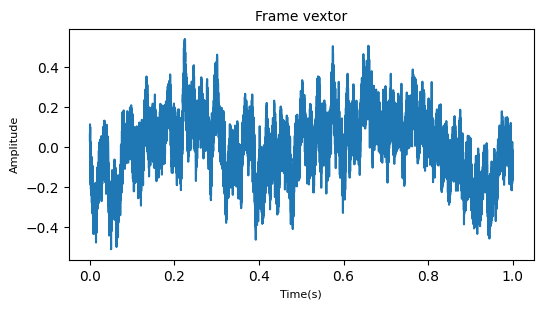

In [16]:
from matplotlib import pyplot as plt

x = [t / bird_sr for t in range(len(y))]         # 시간 간격 x를 계산하는 방법 (230201) 

plt.figure(figsize=(6, 3))
plt.plot(x, y)

plt.title('Frame vextor', fontsize=10)
plt.xlabel('Time(s)', fontsize=8)
plt.ylabel('Amplitude', fontsize=8)

plt.show()

### mel-spectrum 추출

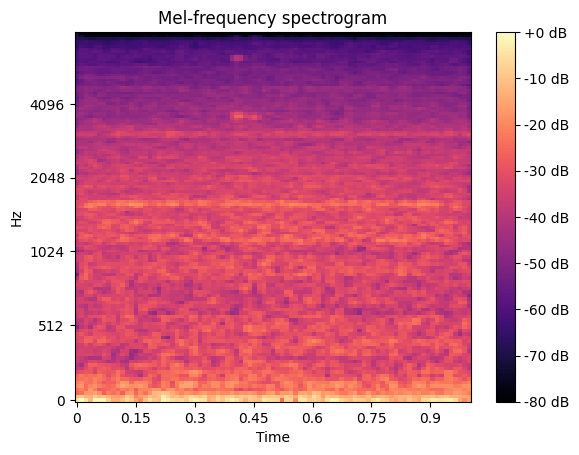

In [17]:
import librosa
from librosa.display import specshow

S = librosa.feature.melspectrogram(y=y, sr=bird_sr)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = specshow(S_dB, x_axis='time', y_axis='mel', sr=bird_sr, fmax=8000, ax=ax)

fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
plt.show()

In [18]:
print(S)

[[2.42416496e+02 6.52558235e+02 2.23721839e+02 ... 2.37319669e+01
  7.44027035e+00 1.62424109e+01]
 [5.11903060e+01 8.01123876e+01 3.40086254e+01 ... 2.06929425e+01
  2.03206406e+01 1.55129743e+01]
 [1.88985448e+00 2.91581172e+00 1.10689479e+01 ... 1.09954583e+01
  8.79672094e+00 4.77649034e+00]
 ...
 [7.81928638e-05 9.53847184e-05 8.37437331e-05 ... 1.04571801e-04
  8.69133212e-05 6.77255277e-05]
 [5.42290523e-05 2.80341134e-05 1.39748128e-05 ... 1.70070810e-05
  1.32364566e-05 1.27133414e-05]
 [4.07280773e-05 1.02794866e-05 1.32246095e-07 ... 1.80728722e-07
  1.43060311e-06 7.80128797e-06]]


In [19]:
S.shape     # Sample Rate 변경에 따라 스펙트럼의 X축 길이가 증가 (230206)

(128, 87)

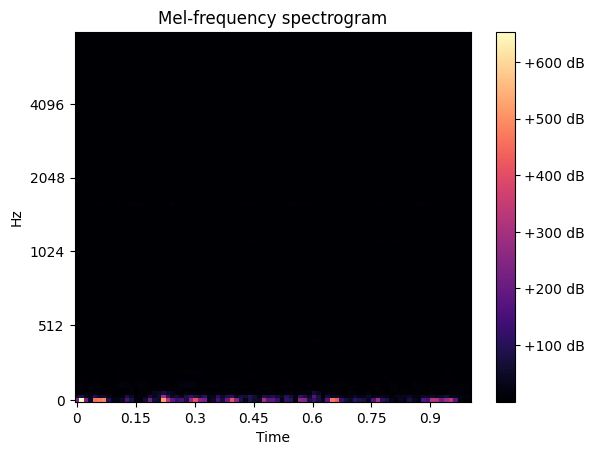

In [20]:
# CNN의 입력으로 사용 가능 : 87 X 128의 2차원 형태   (230206)
# 1024~2048 Hz 대역의 신호가 두드러지는 것이 특징

# 특징만 두드리지게 표현하기 위해 power spectrum을 출력

S = librosa.feature.melspectrogram(y=y, sr=bird_sr)

fig, ax = plt.subplots()
#S_dB = librosa.power_to_db(S, ref=np.max)
img = specshow(S, x_axis='time', y_axis='mel', sr=bird_sr, fmax=8000, ax=ax)

fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
plt.show()

### Frame Vector to Mel-Spectrum (230202)

In [21]:
# 스펙트럼을 담을 빈 벡터 생성

Spectrum_vectors = np.zeros([len(frame_vectors), 128, 87])   # 높이가 총 데이터 갯수이고, 스펙트럼(2D) 128 X 87 인 빈 행렬 (사이즈 수정, 230206)

for i in range(len(frame_vectors)):
    y = frame_vectors[i]
    Spectrum_vectors[i] = librosa.feature.melspectrogram(y=y, sr=bird_sr)
    Spectrum_vectors[i] = librosa.power_to_db(Spectrum_vectors[i], ref=np.max)   # 특성 변경을 위해 추가(230203)

In [22]:
Spectrum_vectors[0]

array([[-15.85042154, -16.53680385, -13.0964803 , ..., -12.06044801,
         -4.6675665 ,  -7.1323017 ],
       [-15.26267994, -11.02077618,  -9.44945681, ...,  -8.93368627,
         -4.24692277,  -6.20112398],
       [-22.38798569, -16.79718973, -19.13580612, ..., -16.37900202,
        -12.58258445, -10.78836129],
       ...,
       [-65.5747413 , -65.21175256, -67.13242505, ..., -66.53805043,
        -67.57061932, -69.56858044],
       [-67.69034437, -71.60276203, -76.09292374, ..., -74.70805991,
        -73.5556461 , -76.59525798],
       [-68.72480223, -74.68450295, -80.        , ..., -80.        ,
        -80.        , -80.        ]])

### 임의의 Spectrum Vector 출력

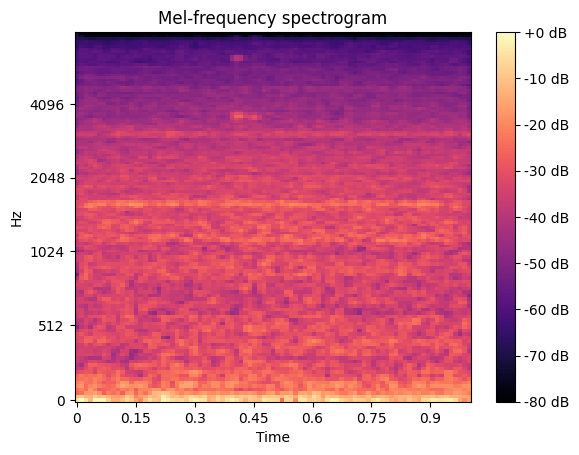

In [23]:
S = Spectrum_vectors[1]

fig, ax = plt.subplots()
#S_dB = librosa.power_to_db(S, ref=np.max)
img = specshow(S, x_axis='time', y_axis='mel', sr=bird_sr, fmax=8000, ax=ax)

fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
plt.show()

### 라벨이 없는 부분을 포함하여 데이터 셋 생성하기

In [24]:
# 다시 라벨이 표기된 부분 호출

import pandas as pd

bird_label = pd.read_csv('bird_label_230201.txt', sep='\t', names=['start(s)', 'end(s)', 'label'])
print(f'label :\n{bird_label}')

label :
     start(s)      end(s)  label
0   13.191798   18.034357      0
1   44.083985   47.924635      0
2   61.450403   64.790099      0
3   83.158426   88.000985      0
4  113.048703  115.720460      0
5  133.253863  140.768179      0
6  168.320669  173.664183      0
7  195.372205  202.385567      0


In [25]:
# 라벨이 없는 구간에 대한 정의

non_label = pd.DataFrame(index=range(0, len(bird_label)-1), columns = ['start(s)', 'end(s)', 'label'])

In [26]:
non_label

,start(s),end(s),label
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN


In [27]:
bird_label['start(s)'][1]

44.083985

In [28]:
# 반복문의 로직상, 처음과 끝 부분은 사용하지 않음
# start - end 사이 시간 데이터만 사용

for i in range(len(non_label)):
    non_label['start(s)'][i] = bird_label['end(s)'][i] + 0.000001
    non_label['end(s)'][i] = bird_label['start(s)'][i+1] - 0.000001
    non_label['label'] = 1

C:\Users\106761\AppData\Local\Temp\ipykernel_2252\2641521602.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_label['start(s)'][i] = bird_label['end(s)'][i] + 0.000001
C:\Users\106761\AppData\Local\Temp\ipykernel_2252\2641521602.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_label['end(s)'][i] = bird_label['start(s)'][i+1] - 0.000001


In [29]:
non_label

,start(s),end(s),label
0,18.034358,44.083984,1
1,47.924636,61.450402,1
2,64.7901,83.158425,1
3,88.000986,113.048702,1
4,115.720461,133.253862,1
5,140.76818,168.320668,1
6,173.664184,195.372204,1


In [30]:
bird_label

,start(s),end(s),label
0,13.191798,18.034357,0
1,44.083985,47.924635,0
2,61.450403,64.790099,0
3,83.158426,88.000985,0
4,113.048703,115.720460,0
5,133.253863,140.768179,0
6,168.320669,173.664183,0
7,195.372205,202.385567,0


In [31]:
# 동일한 설정

# 1초 이상 지속되는 구간만 Frame으로 선정
# 본 예제에서는 라벨 구간이 모두 1초를 초과한다.

frame_size = 1   # 프레임 사이즈 1초, 1초 동안 소리를 판단, 1초 미만의 짧은 레이블 정보는 사용하지 않음
stride = 1       # 충분히 확보되므로 Stride를 크게 잡는다. (230203)

idx = bird_label['end(s)'] - bird_label['start(s)'] >= frame_size
non_label = non_label[idx]

C:\Users\106761\AppData\Local\Temp\ipykernel_2252\3026899701.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_label = non_label[idx]


In [32]:
non_label

,start(s),end(s),label
0,18.034358,44.083984,1
1,47.924636,61.450402,1
2,64.7901,83.158425,1
3,88.000986,113.048702,1
4,115.720461,133.253862,1
5,140.76818,168.320668,1
6,173.664184,195.372204,1


In [33]:
each_n_frames = (np.floor((((non_label['end(s)']-non_label['start(s)'])-frame_size)/stride)+1)).astype(int).values  # np.floor 반올림
total_n_frames = sum(each_n_frames)


# 프레임 벡터를 저장할 빈 벡터 설정

frame_vectors_non = np.zeros((int(total_n_frames), frame_size*bird_sr))
target_vectors_non = np.zeros((int(total_n_frames), 1))

print(frame_vectors_non.shape)
print(target_vectors_non.shape)

(147, 44100)
(147, 1)


In [34]:
current_idx = 0

for i, (start, end, y) in non_label.iterrows():
    for  j in range(each_n_frames[i]):
        
        start_idx = int((start + j * stride) * bird_sr)
        end_idx = start_idx + frame_size * bird_sr
        
        #print(start_idx)
        #print(end_idx)
        
        
        #데이터 길이가 짧아 브로드캐스팅이 안되는 문제 -> 맨 마지막 라인은 멈춤(230203)
        #아래 주석 코드 출력하여 확인
        if current_idx == 37:
            break
        
        frame_vectors_non[current_idx] = bird_audio[start_idx:end_idx]
        target_vectors_non[current_idx] = y
        
        #print(current_idx)
        #print(frame_vectors_non[current_idx].shape)
        
        current_idx += 1


          
#for i in range(len(frame_vectors)):    # 공간상 몇 개만 출력
for i in range(5):
    print(f'{i}-th frame vector[:5]) : {frame_vectors_non[i][:5]}')  # 공간상 5열까지만 벡터 출력


0-th frame vector[:5]) : [-0.20758349 -0.17823745 -0.17828204 -0.19931047 -0.22452416]
1-th frame vector[:5]) : [-0.29492533 -0.27461404 -0.26593718 -0.26526043 -0.26046237]
2-th frame vector[:5]) : [0.15003793 0.15329452 0.16337441 0.15815362 0.13573723]
3-th frame vector[:5]) : [-0.04037579 -0.0103609   0.00607922  0.02427317  0.03914347]
4-th frame vector[:5]) : [ 0.04106572  0.02636925 -0.00151221  0.00021271  0.02351665]


In [35]:
# 스펙트럼을 담을 빈 벡터 생성

Spectrum_vectors_non = np.zeros([len(frame_vectors_non), 128, 87])   # 높이가 총 데이터 갯수이고, 스펙트럼(2D) 128 X 44 인 빈 행렬

for i in range(len(frame_vectors_non)):
    y = frame_vectors_non[i]
    Spectrum_vectors_non[i] = librosa.feature.melspectrogram(y=y, sr=bird_sr)
    Spectrum_vectors_non[i] = librosa.power_to_db(Spectrum_vectors_non[i], ref=np.max)    # 특성 변경을 위해 추가 (230203)

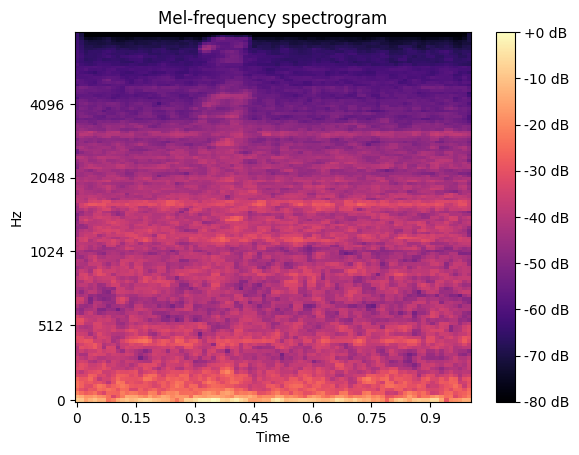

In [36]:
# 임의의 벡터를 출력

S = Spectrum_vectors_non[1]

fig, ax = plt.subplots()
#S_dB = librosa.power_to_db(S, ref=np.max)
img = specshow(S, x_axis='time', y_axis='mel', sr=bird_sr, fmax=8000, ax=ax)

fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
plt.show()

In [37]:
# 1024~2048 Hz 주파수 대역에 특별한 신호가 없음(230202)

### 준비된 스펙트럼 + 라벨 데이터 셋

In [38]:
Spectrum_vectors[0]

array([[-15.85042154, -16.53680385, -13.0964803 , ..., -12.06044801,
         -4.6675665 ,  -7.1323017 ],
       [-15.26267994, -11.02077618,  -9.44945681, ...,  -8.93368627,
         -4.24692277,  -6.20112398],
       [-22.38798569, -16.79718973, -19.13580612, ..., -16.37900202,
        -12.58258445, -10.78836129],
       ...,
       [-65.5747413 , -65.21175256, -67.13242505, ..., -66.53805043,
        -67.57061932, -69.56858044],
       [-67.69034437, -71.60276203, -76.09292374, ..., -74.70805991,
        -73.5556461 , -76.59525798],
       [-68.72480223, -74.68450295, -80.        , ..., -80.        ,
        -80.        , -80.        ]])

In [39]:
Spectrum_vectors_non[0]

array([[-10.34334853,  -8.46421242, -12.00742652, ..., -13.93420891,
         -6.95978079,  -6.03299844],
       [-18.62432157, -20.86823762, -19.10340878, ..., -17.73687733,
        -15.35068073, -11.12759143],
       [-22.64085351, -25.29343544, -22.76836416, ..., -24.54507793,
        -25.3185431 , -18.07180853],
       ...,
       [-63.43124086, -67.69251253, -72.01439298, ..., -69.40602734,
        -66.83007772, -61.41929674],
       [-63.60883613, -69.29836168, -80.        , ..., -80.        ,
        -69.2429675 , -61.51676843],
       [-63.7938587 , -69.82304003, -80.        , ..., -80.        ,
        -69.57391922, -61.65568308]])

In [40]:
Spectrum_vectors_non[0].shape

(128, 87)

In [41]:
 target_vectors[0]

array([0.])

In [42]:
 target_vectors_non[0]

array([1.])

In [43]:
len(Spectrum_vectors)

26

In [44]:
 len(target_vectors)

26

In [45]:
len(Spectrum_vectors_non)

147

In [46]:
len(target_vectors_non)

147

In [47]:
# 라벨 데이터의 갯수가 4배 정도 많음 : 향후 학습 결과의 영향 검토필요(230202)

### PyTorch Custom Dataset

In [48]:
# 기 생성한 데이터 통합하기

Spectrum_vectors_all = np.concatenate((Spectrum_vectors, Spectrum_vectors_non))
target_vectors_all = np.concatenate((target_vectors, target_vectors_non))

In [49]:
len(Spectrum_vectors_all)

173

In [50]:
# Spectrum_vectors_all

In [51]:
len(target_vectors_all)

173

In [52]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [53]:
class CustomDataset(Dataset): 
    def __init__(self, x, y):
            self.x_data = x
            self.y_data = y
            
    def __len__(self): 
        return len(self.x_data)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor([self.x_data[idx]])    # [] 괄호 처리 : 텐서 모양 통일 (128, 44) -> (1, 128, 44)
        y = torch.FloatTensor(self.y_data[idx])      # [] 괄호 처리 : 텐서 모양 통일 (128, 44) -> (1, 128, 44)
        
        return (x, y)

In [54]:
# 학습할 데이터를 결정할 index mask

train_ratio = 0.7

total_n = Spectrum_vectors_all.shape[0]
train_n = int(total_n * train_ratio)

train_idxes = np.random.choice(total_n, train_n, replace=False)

train_mask = np.zeros(shape=total_n, dtype=bool)
train_mask[train_idxes] = True

In [55]:
train_feature = Spectrum_vectors_all[train_mask]
valid_feature = Spectrum_vectors_all[~train_mask]

train_label = target_vectors_all[train_mask]
valid_label = target_vectors_all[~train_mask]

In [56]:
train_dataset = CustomDataset(train_feature, train_label)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

valid_dataset = CustomDataset(valid_feature, valid_label)
vaild_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

In [57]:
valid_dataset[0][0].shape   # 이미지 차원이 이상함 : [1, 128, 44] 의 형태가 되어야 하나, 현재 [128, 44] 형태로 출력
#valid_dataset[0][0]
#valid_label[0]

C:\Users\106761\AppData\Local\Temp\ipykernel_2252\2504729574.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  x = torch.FloatTensor([self.x_data[idx]])    # [] 괄호 처리 : 텐서 모양 통일 (128, 44) -> (1, 128, 44)


torch.Size([1, 128, 87])

In [58]:
train_label.shape

(121, 1)

In [59]:
valid_dataset[0][0]

tensor([[[ -4.3006,   0.0000,  -4.6491,  ..., -14.3929, -19.4303, -16.0397],
         [-11.0543,  -9.1092, -12.8303,  ..., -14.9880, -15.0668, -16.2392],
         [-25.3819, -23.4986, -17.7051,  ..., -17.7341, -18.7030, -21.3551],
         ...,
         [-69.2145, -68.3514, -68.9167,  ..., -67.9520, -68.7553, -69.8387],
         [-70.8039, -73.6693, -76.6927,  ..., -75.8399, -76.9285, -77.1036],
         [-72.0473, -78.0265, -80.0000,  ..., -80.0000, -80.0000, -79.2245]]])

In [60]:
valid_dataset[0]

(tensor([[[ -4.3006,   0.0000,  -4.6491,  ..., -14.3929, -19.4303, -16.0397],
          [-11.0543,  -9.1092, -12.8303,  ..., -14.9880, -15.0668, -16.2392],
          [-25.3819, -23.4986, -17.7051,  ..., -17.7341, -18.7030, -21.3551],
          ...,
          [-69.2145, -68.3514, -68.9167,  ..., -67.9520, -68.7553, -69.8387],
          [-70.8039, -73.6693, -76.6927,  ..., -75.8399, -76.9285, -77.1036],
          [-72.0473, -78.0265, -80.0000,  ..., -80.0000, -80.0000, -79.2245]]]),
 tensor([0.]))

Text(0.5, 1.0, '0.0')

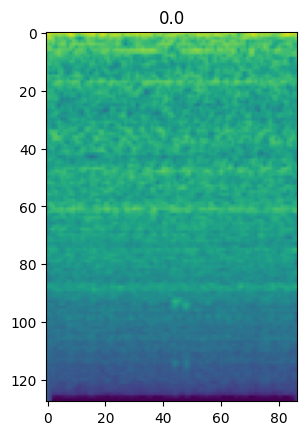

In [61]:
## 데이터셋 시각화해서 확인해보기 (230202)   : 스펙트럼의 사이즈가 (가로 방향) 두배로 커진 것을 확인(230206)

import matplotlib.pyplot as plt

num = 1
plt.imshow(valid_dataset[num][0][0].numpy())
plt.title(valid_dataset[num][1][0].numpy())

Text(0.5, 1.0, '1.0')

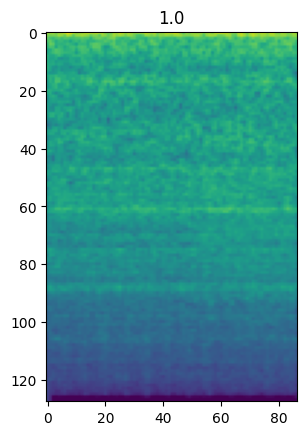

In [62]:
## 데이터셋 시각화해서 확인해보기 (230202)

import matplotlib.pyplot as plt

num = 10
plt.imshow(valid_dataset[num][0][0].numpy())
plt.title(valid_dataset[num][1][0].numpy())

In [63]:
valid_dataset[0][1][0]

tensor(0.)

### CNN 모델 생성

In [64]:
# 이미지 사이즈가 직사각형 (128 X 44) (230201)
# 참고: https://deep-learning-study.tistory.com/376  : 다른 사례 --> 이미지 크롭이 필요한 이유

In [81]:
import torch.nn as nn

class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=(6, 4), stride=2, padding=0),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=(4, 6), stride=2, padding=0),    # 커널 사이즈를 약간 수정 : 정사각형 -> 직사각형(주파수 특성) (230206)
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 전결합층 ?x?x64 inputs -> 1 outputs
        self.fc1 = torch.nn.Linear(1792, 16, bias=True)                             # Sample Rate 변경에 따라 전 결합층 크기 수정 (230206)
        self.fc2 = torch.nn.Linear(16, 1, bias=True)       
        
        self.sigmoid = torch.nn.Sigmoid()     # 출력이 0 or 1이 되도록 이진 분류
        
        # 전결합층 한정으로 가중치 초기
        torch.nn.init.xavier_uniform_(self.fc1.weight)        
        torch.nn.init.zeros_(self.fc1.bias)
        torch.nn.init.xavier_uniform_(self.fc2.weight)        
        torch.nn.init.zeros_(self.fc2.bias)

        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc1(out)        
        out = self.fc2(out)
        out = self.sigmoid(out)
        #out = torch.round(out)    # 텐서 반올림 방법 -> 0 또는 1만 출력 : 미분이 되어야 하므로 반올림하면 안됨.
        
        return out

In [82]:
learning_rate = 0.0001
training_epochs = 50
# batch_size = 100

model = CNN()

#criterion = torch.nn.BCEWithLogitsLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

criterion = torch.nn.BCELoss()  # 이진 분류 0 or 1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [83]:
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(6, 4), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 6), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1792, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [84]:
cost_list =[]
accuracy_list=[]
N_test = 8
correct = 0

for epoch in range(training_epochs):
    cost = 0

    for X, Y in train_loader: # 미니 배치 단위로 데이터 꺼내오기
    
        hypothesis = model(X)
        #hypothesis = torch.round(hypothesis)  # 텐서 반올림 방법 -> 0 또는 1만 출력 ---> 이 부분 삭제 후 정상 학습 (230203)
        
        #print(hypothesis)
        #print(Y)
        
        optimizer.zero_grad()
        cost = criterion(hypothesis, Y)   
        
        #print(cost)     # 갱신되지 않음 (230202)
        
        cost.backward()
        optimizer.step()

        cost_list.append(cost.item())
        


    itr = 0
    
    for x_test, y_test in vaild_loader:
        z = model(x_test)
        z = torch.round(z)
        #print("itr=", itr)
        itr +=1
        #print("predict=", torch.round(z.view(1, -1)))
        #print("label=", y_test.view(1,-1))
        #print("---------------------------------")
        
        correct += (torch.round(z) == y_test).sum().item()
        #print('batch correct=', (torch.round(z) == y_test).sum().item())
        #print("total correct=", correct)
        
        accuracy = correct / N_test
        #print("accuracy=", accuracy)
        accuracy_list.append(accuracy)
        #print("total N=", N_test)
        #print("---------------------------------")
        
        N_test += 8      # 검증 셋의 갯수 -> Dataloader에서 변경 시 동일한 숫자로 변경할 것 (230203)

    #print("epochs=", epoch)        
    #print("accuracy=", accuracy)  

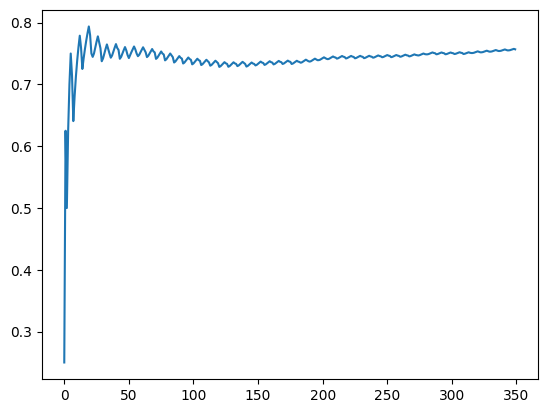

In [85]:
plt.plot(accuracy_list)   # 단순 정답률만 확인한 결과 (230206)  : 정확도 85% (230206 : 커널 모양 수정 기준)
plt.show()

In [70]:
# 고찰 : 코드 수정 문제로 인하여 라벨 영역을 1초 이상으로 작성한 부분
# 실제 Squeak 소음은 0.2초 이내의 짧은 소음으로 라벨링 영역 및 Stride 적용 등에 문제가 있었음(230203)


# Kernel 사이즈를 적당히 조정하는 경우, 최종 정확도가 5% 정도 향상하는 것을 확인 (230206)
# 주파수 특성을 강조할 수 있도록 : 정사각형 커널 -> 직 사각형 커널 로 변경

In [86]:
# 모델 저장
torch.save(model.state_dict(), 'model_squeak.pth')

#https://developers-shack.tistory.com/10

In [87]:
model.load_state_dict(torch.load("model_squeak.pth"))
model.eval()

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(6, 4), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 6), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1792, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [88]:
# 데이터 셋에서 한 개의 데이터를 가져오는 방법 (230206)

S = valid_dataset[10][0].numpy()    # 입력 텐서의 형태에 맞게 val set에서 추출하는 방법
S = torch.FloatTensor([S])           # 대괄호 추가 -> 매트릭스 형태 (1, 1, 128, 44) (230203)

print(S.shape)                           # 입력 텐서 형태 확인 [1, 1, 128, 44]
print(S)    # 입력 텐서(스펙트럼) 실제 확인


with torch.no_grad():
        
    model.eval()
    inputs = S    
    outputs = model(inputs).item()    # 텐서에서 값만 추출하기 item()
    print(np.round(outputs))             # 반올림하여 정답만 추출하기

torch.Size([1, 1, 128, 87])
tensor([[[[-11.4022,  -9.8241,  -9.4528,  ..., -12.3063,  -8.9846, -12.1933],
          [-16.1471, -17.3311, -16.4749,  ..., -16.1084, -12.9838, -13.2973],
          [-19.8390, -23.3469, -25.7846,  ..., -20.6006, -19.4099, -18.8771],
          ...,
          [-63.7917, -67.1813, -68.9287,  ..., -68.1272, -69.7491, -71.6710],
          [-64.0368, -69.8488, -80.0000,  ..., -80.0000, -78.5275, -75.7780],
          [-64.4541, -70.4907, -80.0000,  ..., -80.0000, -80.0000, -79.3505]]]])
1.0


In [74]:
# 고찰 : 음원 파일을 librosa 모듈로 로딩시 Sample rate를 22050 -> 44100으로 변경
# 스펙트럼의 가로 방향을 더 상세하게 보는 효과가 있으나,
# 실제로 Squeak을 판단하는 기준은 주파수 축의 작은 신호이므로, 예측 정확도 향상 효과는 없는 것으로 판단 (230206)

In [75]:
# 아이디어 :
# 특정 소음이 없는 경우는 제외하고, 소음을 구분할 수 있는지? 
# 학습 순서의 문제 : 특정 소음을 집중 학습하고, 다른 소음을 순차적으로 학습해도 상관 없는지?
# 특정인의 음성을 구분할 수 있는지? -> 암호화 처리 방법?
# 녹음된 음성과 실제 육성을 구분할 수 있는지? : 기기의 Sample Rate를 공개하지 않고,
# 녹음된 음성의 Sample Rate는 일반적으로 정해진 값이므로.....
# 음성 암호키 가능 여부 : 10초간 음성을 입력받아 암호키로 활용할 수 있는지?
# mel-spectrum 외에 다른 특성 맵을 사용한다면 (230320)